<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex04/Pedro_Luis_Azevedo_Costa/Aula_4_Exerc%C3%ADcio_175857.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

Este exercicío consiste em treinar um modelo de uma única camada linear no MNIST **sem** usar as seguintes funções do pytorch:

- torch.nn.Linear
- torch.nn.CrossEntropyLoss
- torch.nn.NLLLoss
- torch.nn.LogSoftmax
- torch.optim.SGD
- torch.utils.data.Dataloader

## Importação das bibliotecas

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torchvision.datasets import MNIST

## Fixando as seeds

In [50]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [51]:
batch_size = 50

### Carregamento, criação dataset e do dataloader

In [52]:
dataset_dir = '../data/'

dataset_train_full = MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
print(dataset_train_full.data.shape)
print(dataset_train_full.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


### Usando apenas 1000 amostras do MNIST

Neste exercício utilizaremos 1000 amostras de treinamento.

In [53]:
indices = torch.randperm(len(dataset_train_full))[:1000]
dataset_train = torch.utils.data.Subset(dataset_train_full, indices)



In [54]:
len(list(dataset_train))

1000

In [55]:
def sample_subset(subset, idx_ini, n_samples):

      ## Nesta parte do código me inspirei na solucao da Larissa Santesso
      filtered_subset = subset[idx_ini:idx_ini + n_samples]
      filtered_subset = list(zip(*filtered_subset)) 
      filtered_subset[0] = torch.stack(filtered_subset[0],dim=0)
      filtered_subset[1] = torch.tensor(filtered_subset[1]).long()
      return filtered_subset[0], filtered_subset[1]

                  

x_train_test, y_target_test = sample_subset(list(dataset_train), 10, 1)

x_train_test


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [56]:
from typing import Counter
# Escreva aqui o equivalente do código abaixo:
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

class DataLoader():
    def __init__(self, dataset, batch_size, shuffle):
        self.dataset = list(dataset)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.index_counter = 0
        self.n_batches = int(len(self.dataset)/self.batch_size)
    
    def __len__(self):
        return self.n_batches
    
    def __iter__(self):
        self.index_counter = 0
        return self
    def __next__(self):
        if self.index_counter >= len(self.dataset)/self.batch_size:
            raise StopIteration
        else:
            sample_data, sample_target = sample_subset(self.dataset, self.index_counter*self.batch_size, self.batch_size)
            self.index_counter += 1
            return sample_data, sample_target

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)


In [57]:
print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 20

Dimensões dos dados de um minibatch: torch.Size([50, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Modelo

In [58]:
# Escreva aqui o codigo para criar um modelo cujo o equivalente é: 
# model = torch.nn.Linear(28*28, 10)
# model.load_state_dict(dict(weight=torch.zeros(model.weight.shape), bias=torch.zeros(model.bias.shape)))

class Linear():
    def __init__(self, n_in, n_out):
        self.n_in = n_in
        self.n_out = n_out
        self.weight = torch.zeros(n_out, n_in, requires_grad=True)
        self.bias = torch.zeros(n_out, requires_grad=True)
    
    def __call__(self, input):
        output = torch.matmul(input, self.weight.T) + self.bias
        return output

    def parameters(self):
        return [self.weight, self.bias]

model = Linear(28*28, 10)
input = torch.zeros([50, 28*28])

x = model(input)
print(x.shape)
    



torch.Size([50, 10])


## Treinamento

### Inicialização dos parâmetros

In [59]:
n_epochs = 50
lr = 0.1

## Definição da Loss



In [60]:
# Escreva aqui o equivalente de:
# criterion = torch.nn.CrossEntropyLoss()








def criterion(pred, target):

    exp = torch.exp(pred)
    sum = exp.sum(axis=1) 
    log = torch.log(sum)
    z_y = pred[range(len(exp)), target]
    H = (-z_y + log).sum()/len(exp)
    return H


model = Linear(28*28, 10)


inputs = x_train.view(-1, 28 * 28)
# predict da rede
outputs = model(inputs)

# calcula a perda
loss = criterion(outputs, y_train)
loss


tensor(2.3026, grad_fn=<DivBackward0>)

# Definição do Optimizer

In [61]:
# Escreva aqui o equivalente de:
# optimizer = torch.optim.SGD(model.parameters(), lr)

class SGD():
    def __init__(self, parameters, lr):
        print(parameters)
        self.parameters = parameters
        self.lr = lr

    def step(self):
        for parameter in self.parameters:
            parameter.data = parameter.data - self.lr * parameter.grad
        return

    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad = torch.zeros(parameter.data.shape)
        return

    
optimizer = SGD(model.parameters(), lr)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]


### Laço de treinamento dos parâmetros

In [62]:
epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0
for i in range(n_epochs):
    # Substitua aqui o loader_train de acordo com sua implementação do dataloader.
    for x_train, y_train in loader_train:
        # Transforma a entrada para uma dimensão
        inputs = x_train.view(-1, 28 * 28)
        # predict da rede
        outputs = model(inputs)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        # Escreva aqui o código cujo o resultado é equivalente às 3 linhas abaixo:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(dataset_train))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')


Epoch: 0/49 Loss: 1.1979684829711914
Epoch: 1/49 Loss: 0.867622971534729
Epoch: 2/49 Loss: 0.7226786613464355
Epoch: 3/49 Loss: 0.6381281018257141
Epoch: 4/49 Loss: 0.5809750556945801
Epoch: 5/49 Loss: 0.5387411713600159
Epoch: 6/49 Loss: 0.5056463479995728
Epoch: 7/49 Loss: 0.47862708568573
Epoch: 8/49 Loss: 0.4558936655521393
Epoch: 9/49 Loss: 0.4363219141960144
Epoch: 10/49 Loss: 0.4191650152206421
Epoch: 11/49 Loss: 0.403904527425766
Epoch: 12/49 Loss: 0.39016804099082947
Epoch: 13/49 Loss: 0.3776799738407135
Epoch: 14/49 Loss: 0.3662315011024475
Epoch: 15/49 Loss: 0.35566142201423645
Epoch: 16/49 Loss: 0.34584280848503113
Epoch: 17/49 Loss: 0.33667415380477905
Epoch: 18/49 Loss: 0.3280735909938812
Epoch: 19/49 Loss: 0.31997358798980713
Epoch: 20/49 Loss: 0.3123184144496918
Epoch: 21/49 Loss: 0.30506110191345215
Epoch: 22/49 Loss: 0.2981624901294708
Epoch: 23/49 Loss: 0.29158854484558105
Epoch: 24/49 Loss: 0.2853103280067444
Epoch: 25/49 Loss: 0.27930304408073425
Epoch: 26/49 Loss:

### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

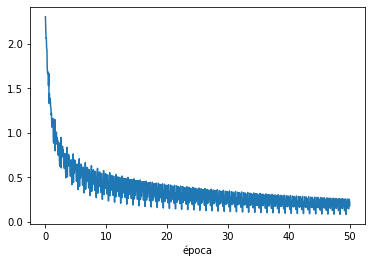

In [63]:
plt.plot(epochs, loss_history)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

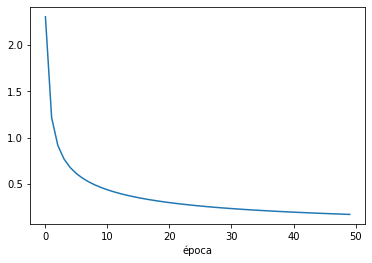

In [64]:
n_batches_train = len(loader_train)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

In [65]:
# Assert do histórico de losses
target_loss_epoch_end = np.array([
    1.1979684829711914,
    0.867622971534729,
    0.7226786613464355,
    0.6381281018257141,
    0.5809749960899353,
    0.5387411713600159,
    0.5056464076042175,
    0.4786270558834076,
    0.4558936357498169,
    0.4363219141960144,
    0.4191650450229645,
    0.4039044976234436,
    0.3901679515838623,
    0.3776799440383911,
    0.3662314713001251,
    0.35566139221191406,
    0.34584277868270874,
    0.33667415380477905,
    0.32807353138923645,
    0.31997355818748474,
    0.312318354845047,
    0.3050611615180969,
    0.29816246032714844,
    0.29158851504325867,
    0.28531041741371155,
    0.2793029546737671,
    0.273544579744339,
    0.2680158317089081,
    0.26270008087158203,
    0.2575823664665222,
    0.25264936685562134,
    0.24788929522037506,
    0.24329163134098053,
    0.23884665966033936,
    0.23454584181308746,
    0.23038141429424286,
    0.22634628415107727,
    0.22243399918079376,
    0.2186385989189148,
    0.21495483815670013,
    0.21137762069702148,
    0.20790249109268188,
    0.20452524721622467,
    0.20124195516109467,
    0.19804897904396057,
    0.1949428766965866,
    0.19192075729370117,
    0.188979372382164,
    0.18611609935760498,
    0.1833282858133316])

assert np.allclose(np.array(loss_epoch_end), target_loss_epoch_end, atol=1e-6)

## Exercício 

Escreva um código que responda às seguintes perguntas:

Qual é a amostra classificada corretamente, com maior probabilidade?

Qual é a amostra classificada erradamente, com maior probabilidade?

Qual é a amostra classificada corretamente, com menor probabilidade?

Qual é a amostra classificada erradamente, com menor probabilidade?

In [66]:
# Escreva o código aqui:
x_train_full = torch.Tensor([])
y_train_full = torch.Tensor([])
for x_train_join, y_train_join in loader_train:
    x_train_full = torch.cat((x_train_full, x_train_join))
    y_train_full = torch.cat((y_train_full, y_train_join))

inputs = x_train_full.view(-1, 28 * 28)
outputs = model(inputs)



logit_exp = torch.exp(outputs)
logit_sum = logit_exp.sum(axis=1)
logit = (logit_exp.T/logit_sum).T

max_correct = {"val": 0, "index": 0}
max_wrong = {"val": 0, "index": 0}
min_correct = {"val": 1, "index": 0}
min_wrong = {"val": 1, "index": 0}
for index, train in enumerate(logit):
    correct_index = y_train_full[index].item()
    max_value = train.max()
    min_value = train.min()
    max_index = (train == max_value).nonzero(as_tuple=False)[0][0].item()

    # Amostra correta
    if max_index == correct_index:
        # maior probabilidade
        if max_value > max_correct["val"]:
            max_correct["val"] = max_value
            max_correct["index"] = index
        # menor probabilidade
        if max_value < min_correct["val"]:
            min_correct["val"] = max_value
            min_correct["index"] = index
    # Amostra errada
    else:
        # maior probabilidade
        if max_value > max_wrong["val"]:
            max_wrong["val"] = max_value
            max_wrong["index"] = index
        # menor probabilidade
        if max_value < min_wrong["val"]:
            min_wrong["val"] = max_value
            min_wrong["index"] = index




print(max_correct)
print(min_correct)
print(max_wrong)
print(min_wrong)

{'val': tensor(1.0000, grad_fn=<MaxBackward1>), 'index': 183}
{'val': tensor(0.3353, grad_fn=<MaxBackward1>), 'index': 532}
{'val': tensor(0.8530, grad_fn=<MaxBackward1>), 'index': 271}
{'val': tensor(0.2892, grad_fn=<MaxBackward1>), 'index': 68}


Probabilidade:  0.9999896883964539


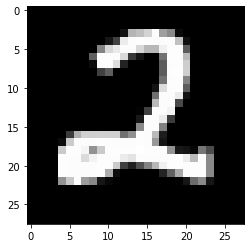

In [67]:
# Amostra classificada corretamente com a maior probabilidade
plt.imshow(x_train_full[max_correct["index"]].numpy().reshape(28,28), cmap="gray")

print("Probabilidade: ", max_correct["val"].item())

Probabilidade:  0.33532655239105225


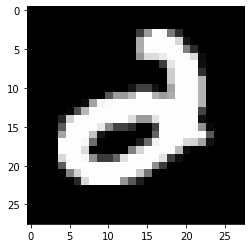

In [68]:
# Amostra classificada corretamente com a menor probabilidade
plt.imshow(x_train_full[min_correct["index"]].numpy().reshape(28,28), cmap="gray")

print("Probabilidade: ", min_correct["val"].item())

Probabilidade:  0.853049635887146


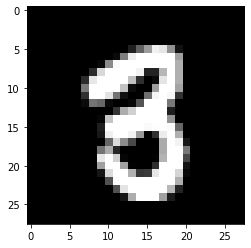

In [69]:
# Amostra classificada erradamente com a maior probabilidade
plt.imshow(x_train_full[max_wrong["index"]].numpy().reshape(28,28), cmap="gray")

print("Probabilidade: ", max_wrong["val"].item())

Probabilidade:  0.28921395540237427


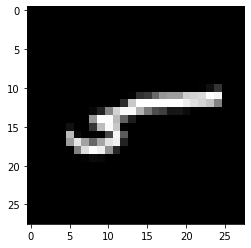

In [70]:
# Amostra classificada erradamente com a menor probabilidade
plt.imshow(x_train_full[min_wrong["index"]].numpy().reshape(28,28), cmap="gray")

print("Probabilidade: ", min_wrong["val"].item())

## Exercício Bonus

Implemente um dataloader que aceite como parâmetro de entrada a distribuição probabilidade das classes que deverão compor um batch.
Por exemplo, se a distribuição de probabilidade passada como entrada for:

`[0.01, 0.01, 0.72, 0.2, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]`

Em média, 72% dos exemplos do batch deverão ser da classe 2, 20% deverão ser da classe 3, e os demais deverão ser das outras classes.

Mostre também que sua implementação está correta.
